## Astrophysics Report #2
This is the code for my (Michael Sell) Astrophysics simulated orbit. 



### Imports

In [1]:
# Import Libraries
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
import astropy.units as u
from galpy.orbit import Orbit
import galpy.util.coords as coords
from galpy.potential import MWPotential2014
from galpy.potential import McMillan17
# from galpy.potential import Irrgang13I
from galpy.potential.mwpotentials import McMillan17, Irrgang13I
from galpy.util.conversion import get_physical

np.random.seed(0)
N = 15000   #Number of objects

# Physical Paramters
R0 = 8*u.kpc #kpc
z0 = 0.025*u.kpc #kpc
V0 = 220*u.km/u.s   #km/s
u_sun = -11.1 #km/s
# v_sun = 7.25*u.km / u.s  #km/s
v_sun = [-11.1, 7.25, 12.24]*u.km / u.s  #km/s
w_sun = 12.24 #km/s


### Toomre Diagram
Create velocity ellipsoid diagram for white dwarfs, plotting random selection of velocities in a Toomre diagram, and converting one for each into cylindrical coordinates.

[43.73458329 -6.29470963 14.46198877]
[  3.84906271 -94.687198    -4.64540925]
[-26.89267893  14.15948618 -13.75288244]
/var/folders/hj/93g2dpgj78s9f05h5s0b10mw0000gn/T/ipykernel_61722/730096648.py:18: RuntimeWarning: invalid value encountered in sqrt
  ax1.plot(nUVW_halo[:,1],np.sqrt(nUVW_halo[:,0]**2 + nUVW_halo[:,2]), marker='.', ms=3, ls='none', label='halo')

/var/folders/hj/93g2dpgj78s9f05h5s0b10mw0000gn/T/ipykernel_61722/730096648.py:19: RuntimeWarning: invalid value encountered in sqrt
  ax1.plot(nUVW_thick[:,1],np.sqrt(nUVW_thick[:,0]**2 + nUVW_thick[:,2]), marker='.', ms=3, ls='none', label='thick disk')

/var/folders/hj/93g2dpgj78s9f05h5s0b10mw0000gn/T/ipykernel_61722/730096648.py:20: RuntimeWarning: invalid value encountered in sqrt
  ax1.plot(nUVW_thin[:,1],np.sqrt(nUVW_thin[:,0]**2 + nUVW_thin[:,2]), marker='.', ms=3, ls='none', label='thin disk')



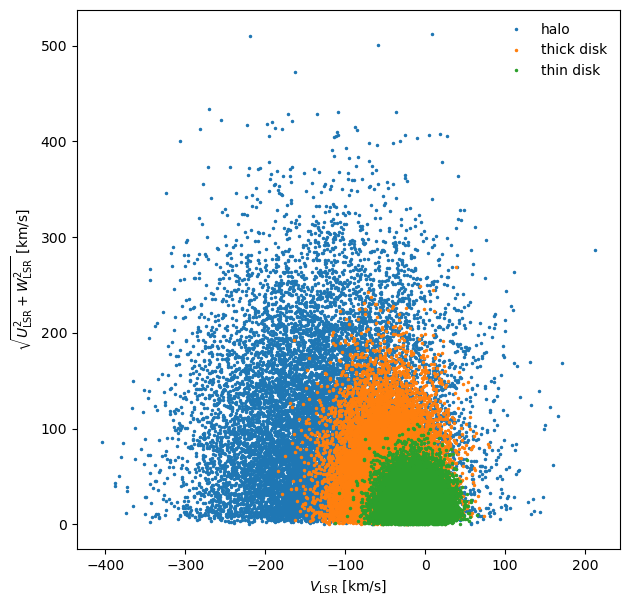

In [2]:

# velocity ellipsoid
UVW_thin = np.array([[-4.23,27.19],[-14.67,20.93],[-4.78,19.66]])
UVW_thick = np.array([[-29.82,59.94],[-48.63,34.69],[-6.43,39.7]])
UVW_halo = np.array([[-41.17,120.46],[-123.34,78.29],[-6.79,78.31]])

nUVW_thin = np.random.normal(UVW_thin[:,0],UVW_thin[:,1],(N,3))
nUVW_thick = np.random.normal(UVW_thick[:,0],UVW_thick[:,1],(N,3))
nUVW_halo = np.random.normal(UVW_halo[:,0],UVW_halo[:,1],(N,3))

print(nUVW_thin[0])
print(nUVW_thick[0])
print(nUVW_halo[0])

fig = pl.figure(figsize=(7,7))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(111)

ax1.plot(nUVW_halo[:,1],np.sqrt(nUVW_halo[:,0]**2 + nUVW_halo[:,2]), marker='.', ms=3, ls='none', label='halo')
ax1.plot(nUVW_thick[:,1],np.sqrt(nUVW_thick[:,0]**2 + nUVW_thick[:,2]), marker='.', ms=3, ls='none', label='thick disk')
ax1.plot(nUVW_thin[:,1],np.sqrt(nUVW_thin[:,0]**2 + nUVW_thin[:,2]), marker='.', ms=3, ls='none', label='thin disk')

ax1.set_xlabel(r'$V_{\rm LSR}$ [km/s]')
ax1.set_ylabel(r'$\sqrt{U^2_{\rm LSR} + W^2_{\rm LSR}}$ [km/s]')

pl.legend(frameon=False)


pl.show()



### Convert to Cylindrical Coords
We also convert the tuples into arrays in this block and construct matrices of Nx3. Each row corresponds to a different star and each column is a velocity component, which was converted to cylindrical coordinates

In [3]:
# Convert to Cylindrical Coordinates
XYZ = [8.030,0.0,0.025]

# Create 3 different matrices for each type of star.
RTZ_thin = coords.rect_to_cyl(XYZ[0], XYZ[1], XYZ[2])
vRTZ_thin = coords.rect_to_cyl_vec(nUVW_thin[:,0],nUVW_thin[:,1],nUVW_thin[:,2],XYZ[0], XYZ[1], XYZ[2], cyl=False)

RTZ_thick = coords.rect_to_cyl(XYZ[0], XYZ[1], XYZ[2])
vRTZ_thick = coords.rect_to_cyl_vec(nUVW_thick[:,0],nUVW_thick[:,1],nUVW_thick[:,2],XYZ[0], XYZ[1], XYZ[2], cyl=False)

RTZ_halo = coords.rect_to_cyl(XYZ[0], XYZ[1], XYZ[2])
vRTZ_halo = coords.rect_to_cyl_vec(nUVW_halo[:,0],nUVW_halo[:,1],nUVW_halo[:,2],XYZ[0], XYZ[1], XYZ[2], cyl=False)


# We can now convert the tuples into arrays to modify later
RTZ_thin=np.array(RTZ_thin)
RTZ_thick=np.array(RTZ_thick).T
RTZ_halo=np.array(RTZ_halo).T

vRTZ_thin=np.array(vRTZ_thin).T
vRTZ_thick=np.array(vRTZ_thick).T
vRTZ_halo=np.array(vRTZ_halo).T


### Integration (e, L_z Calculation)
Create three orbits for thin-disk, thick-disk, and halo white dwarfs, respectivelly. After, we create an array of timesteps and integrate the orbits. We also create different vectors to store multiple orbits.

In [4]:
# star_thin = [RTZ_thin[0]/8.,vRTZ_thin[0]/220,1+vRTZ_thin[1]/220,RTZ_thin[2]/8,vRTZ_thin[2]/220,RTZ_thin[1]]
# print(star_thin)
# star_thick = [RTZ_thick[0]/8.,vRTZ_thick[0]/220,1+vRTZ_thick[1]/220,RTZ_thick[2]/8,vRTZ_thick[2]/220,RTZ_thick[1]]
# print(star_thick)
# star_halo = [RTZ_halo[0]/8.,vRTZ_halo[0]/220,1+vRTZ_halo[1]/220,RTZ_halo[2]/8,vRTZ_halo[2]/220,RTZ_halo[1]]
# print(star_halo)
np.random.seed(0)

# Initialize Vectors
star_thin=np.zeros((N,6))
star_thick=np.zeros((N,6))
star_halo=np.zeros((N,6))

for i in range(N):
    star_thin[i, 0] = RTZ_thin[0]/8.
    star_thin[i, 1] = vRTZ_thin[i, 0] / 220. 
    star_thin[i, 2] = 1 + vRTZ_thin[i, 1] / 220. 
    star_thin[i, 3] = RTZ_thin[2] / 8. 
    star_thin[i, 4] = vRTZ_thin[i, 2] / 220. 
    star_thin[i, 5] = RTZ_thin[1]  

    star_thick[i, 0] = RTZ_thick[0]/8.
    star_thick[i, 1] = vRTZ_thick[i, 0] / 220. 
    star_thick[i, 2] = 1 + vRTZ_thick[i, 1] / 220. 
    star_thick[i, 3] = RTZ_thick[2] / 8. 
    star_thick[i, 4] = vRTZ_thick[i, 2] / 220. 
    star_thick[i, 5] = RTZ_thick[1]

    star_halo[i, 0] = RTZ_halo[0]/8.
    star_halo[i, 1] = vRTZ_halo[i, 0] / 220. 
    star_halo[i, 2] = 1 + vRTZ_halo[i, 1] / 220. 
    star_halo[i, 3] = RTZ_halo[2] / 8. 
    star_halo[i, 4] = vRTZ_halo[i, 2] / 220. 
    star_halo[i, 5] = RTZ_halo[1]


ts = np.linspace(0,2,1000)*u.Gyr

# Integrating ONE orbit
o_thin = Orbit(star_thin[0], ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
o_thin.integrate(ts,MWPotential2014)

o_thick = Orbit(star_thick[0], ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
o_thick.integrate(ts,MWPotential2014)

o_halo = Orbit(star_halo[0], ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
o_halo.integrate(ts,MWPotential2014)


# Integrating ALL orbits
a_thin = Orbit(star_thin, ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
a_thin.integrate(ts,MWPotential2014)

a_thick = Orbit(star_thick, ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
a_thick.integrate(ts,MWPotential2014)

a_halo = Orbit(star_halo, ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
a_halo.integrate(ts,MWPotential2014)


# printing eccentricity and angular momentum (z component)
# print('e = ', round(o_thin.e(),3), 'Lz = ', o_thin.Lz(quantity=True))
# print('e = ', round(o_thick.e(),3), 'Lz = ', o_thick.Lz(quantity=True))
# print('e = ', round(o_halo.e(),3), 'Lz = ', o_halo.Lz(quantity=True))

# Without round function
print('e = ', o_thin.e(), 'Lz = ', o_thin.Lz(quantity=True))
print('e = ', o_thick.e(), 'Lz = ', o_thick.Lz(quantity=True))
print('e = ', o_halo.e(), 'Lz = ', o_halo.Lz(quantity=True))



e =  0.15023276982721295 Lz =  1716.0534816801414 km kpc / s
e =  0.45744419372809386 Lz =  1006.2618000451755 km kpc / s
e =  0.11792901173619037 Lz =  1880.3006740306503 km kpc / s


### Extended Report #6: Galactic Potential 
#### For McMillan17 Potential:

In [5]:
# np.random.seed(0)

# # Initialize Vectors
# star_thin=np.zeros((N,6))
# star_thick=np.zeros((N,6))
# star_halo=np.zeros((N,6))

# for i in range(N):
#     star_thin[i, 0] = RTZ_thin[0]/8.
#     star_thin[i, 1] = vRTZ_thin[i, 0] / 220. 
#     star_thin[i, 2] = 1 + vRTZ_thin[i, 1] / 220. 
#     star_thin[i, 3] = RTZ_thin[2] / 8. 
#     star_thin[i, 4] = vRTZ_thin[i, 2] / 220. 
#     star_thin[i, 5] = RTZ_thin[1]  

#     star_thick[i, 0] = RTZ_thick[0]/8.
#     star_thick[i, 1] = vRTZ_thick[i, 0] / 220. 
#     star_thick[i, 2] = 1 + vRTZ_thick[i, 1] / 220. 
#     star_thick[i, 3] = RTZ_thick[2] / 8. 
#     star_thick[i, 4] = vRTZ_thick[i, 2] / 220. 
#     star_thick[i, 5] = RTZ_thick[1]

#     star_halo[i, 0] = RTZ_halo[0]/8.
#     star_halo[i, 1] = vRTZ_halo[i, 0] / 220. 
#     star_halo[i, 2] = 1 + vRTZ_halo[i, 1] / 220. 
#     star_halo[i, 3] = RTZ_halo[2] / 8. 
#     star_halo[i, 4] = vRTZ_halo[i, 2] / 220. 
#     star_halo[i, 5] = RTZ_halo[1]


# ts = np.linspace(0,2,100)*u.Gyr

# o_thin = Orbit(**get_physical(McMillan17))
# o_thin.integrate(ts,McMillan17)

# o_thick = Orbit(**get_physical(McMillan17))
# o_thick.integrate(ts,McMillan17)

# o_halo = Orbit(**get_physical(McMillan17))
# o_halo.integrate(ts,McMillan17)

# # Integrating All Orbits

# a_thin = Orbit(**get_physical(McMillan17))
# a_thin.integrate(ts,McMillan17)

# a_thick = Orbit(**get_physical(McMillan17))
# a_thick.integrate(ts,McMillan17)

# a_halo = Orbit(**get_physical(McMillan17))
# a_halo.integrate(ts,McMillan17)


# # printing eccentricity and angular momentum (z component)
# print('e = ', o_thin.e(), 'Lz = ', o_thin.Lz(quantity=True))
# print('e = ', o_thick.e(), 'Lz = ', o_thick.Lz(quantity=True))
# print('e = ', o_halo.e(), 'Lz = ', o_halo.Lz(quantity=True))

#### For Irrgang13I Potential:

In [6]:
# np.random.seed(0)

# # Initialize Vectors
# star_thin=np.zeros((N,6))
# star_thick=np.zeros((N,6))
# star_halo=np.zeros((N,6))

# for i in range(N):
#     star_thin[i, 0] = RTZ_thin[0]/8.
#     star_thin[i, 1] = vRTZ_thin[i, 0] / 220. 
#     star_thin[i, 2] = 1 + vRTZ_thin[i, 1] / 220. 
#     star_thin[i, 3] = RTZ_thin[2] / 8. 
#     star_thin[i, 4] = vRTZ_thin[i, 2] / 220. 
#     star_thin[i, 5] = RTZ_thin[1]  

#     star_thick[i, 0] = RTZ_thick[0]/8.
#     star_thick[i, 1] = vRTZ_thick[i, 0] / 220. 
#     star_thick[i, 2] = 1 + vRTZ_thick[i, 1] / 220. 
#     star_thick[i, 3] = RTZ_thick[2] / 8. 
#     star_thick[i, 4] = vRTZ_thick[i, 2] / 220. 
#     star_thick[i, 5] = RTZ_thick[1]

#     star_halo[i, 0] = RTZ_halo[0]/8.
#     star_halo[i, 1] = vRTZ_halo[i, 0] / 220. 
#     star_halo[i, 2] = 1 + vRTZ_halo[i, 1] / 220. 
#     star_halo[i, 3] = RTZ_halo[2] / 8. 
#     star_halo[i, 4] = vRTZ_halo[i, 2] / 220. 
#     star_halo[i, 5] = RTZ_halo[1]


# ts = np.linspace(0,2,100)*u.Gyr

# o_thin = Orbit(**get_physical(Irrgang13I))
# o_thin.integrate(ts,Irrgang13I)

# o_thick = Orbit(**get_physical(Irrgang13I))
# o_thick.integrate(ts,Irrgang13I)


# o_halo = Orbit(**get_physical(Irrgang13I))
# o_halo.integrate(ts,Irrgang13I)


# # we integrate all orbits


# a_thin = Orbit(**get_physical(Irrgang13I))
# a_thin.integrate(ts,Irrgang13I)

# a_thick = Orbit(**get_physical(Irrgang13I))
# a_thick.integrate(ts,Irrgang13I)

# a_halo = Orbit(**get_physical(Irrgang13I))
# a_halo.integrate(ts,Irrgang13I)


# # printing eccentricity and angular momentum (z component)
# print('e = ', o_thin.e(), 'Lz = ', o_thin.Lz(quantity=True))
# print('e = ', o_thick.e(), 'Lz = ', o_thick.Lz(quantity=True))
# print('e = ', o_halo.e(), 'Lz = ', o_halo.Lz(quantity=True))

### Plotting Orbits

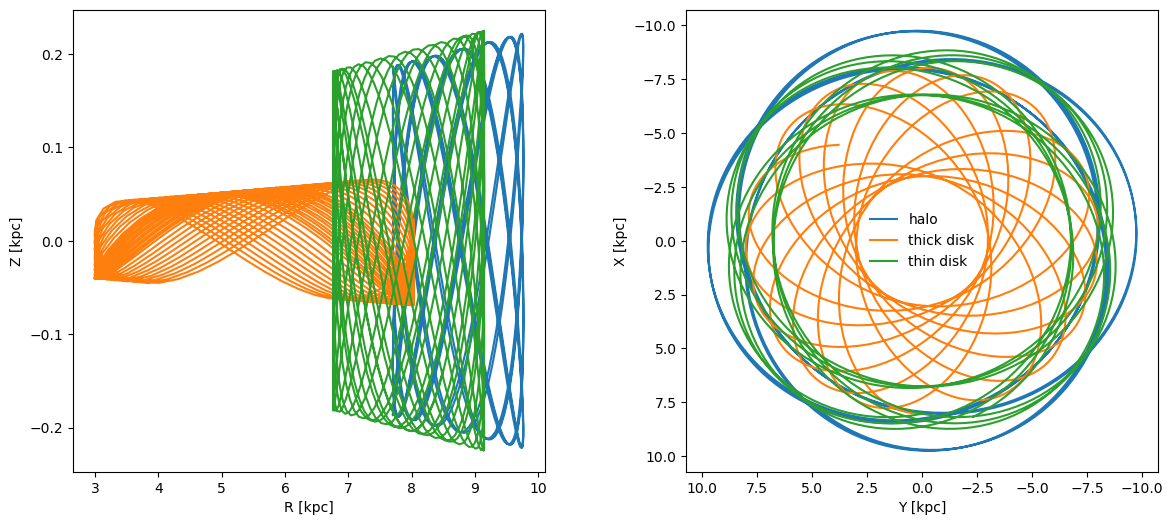

In [7]:
# Plotting orbits
fig = pl.figure(figsize=(14,6))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(121)

ax1.plot(o_halo.R(ts,quantity=True),o_halo.z(ts,quantity=True))
ax1.plot(o_thick.R(ts,quantity=True),o_thick.z(ts,quantity=True))
ax1.plot(o_thin.R(ts,quantity=True),o_thin.z(ts,quantity=True))


ax1.set_xlabel('R [kpc]')
ax1.set_ylabel('Z [kpc]')


ax2 = fig.add_subplot(122)

ax2.plot(o_halo.y(ts,quantity=True),o_halo.x(ts,quantity=True), label='halo')
ax2.plot(o_thick.y(ts,quantity=True),o_thick.x(ts,quantity=True), label='thick disk')
ax2.plot(o_thin.y(ts,quantity=True),o_thin.x(ts,quantity=True), label='thin disk')

ax2.set_xlabel('Y [kpc]')
ax2.set_ylabel('X [kpc]')

pl.legend(frameon=False)

ax2.invert_xaxis()
ax2.invert_yaxis()
pl.show()


### Creating a 3-Dimensional Plot of the trajectories (Extra)

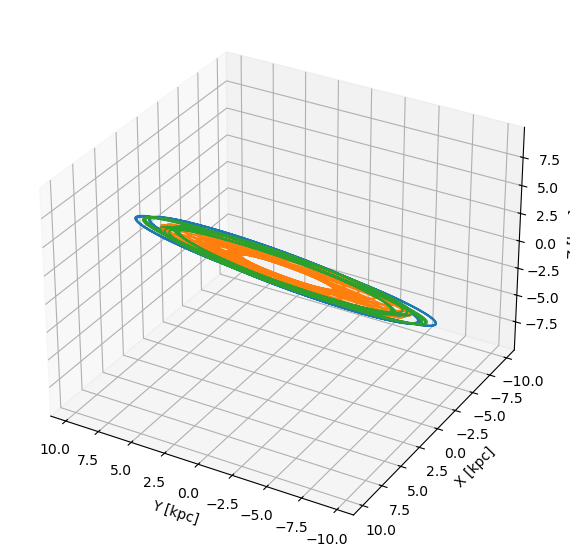

In [8]:
fig = pl.figure(figsize=(7,7))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(projection='3d')

ax1.plot(o_halo.y(ts,quantity=True),o_halo.x(ts,quantity=True), o_halo.x(ts,quantity=True), label='halo')
ax1.plot(o_thick.y(ts,quantity=True),o_thick.x(ts,quantity=True), o_thick.x(ts,quantity=True), label='thick disk')
ax1.plot(o_thin.y(ts,quantity=True),o_thin.x(ts,quantity=True), o_thin.x(ts,quantity=True), label='thin disk')


ax1.set_xlabel('Y [kpc]')
ax1.set_ylabel('X [kpc]')
ax1.set_zlabel('Z [kpc]')

ax1.invert_xaxis()
ax1.invert_yaxis()
pl.show()

### Plotting Angular Momentum L_z vs Orbital Eccentricity e

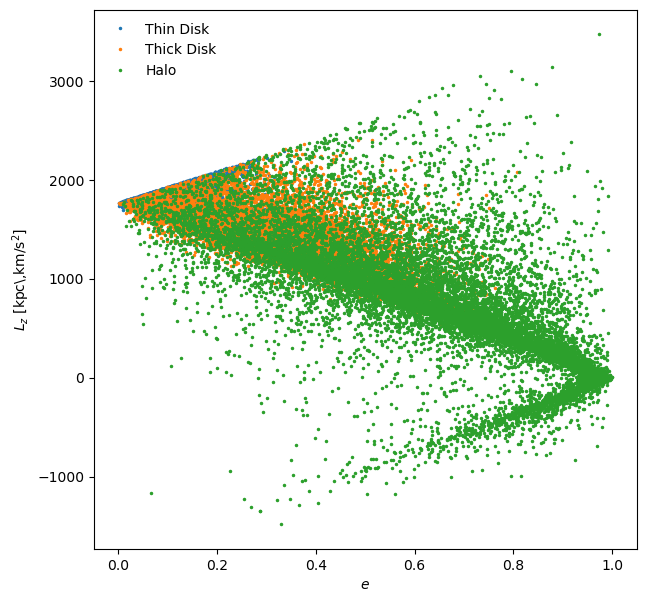

In [9]:
fig = pl.figure(figsize=(7,7))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(111)

# Plotting for all integrated orbits
ax1.plot(a_thin.e(),a_thin.Lz(quantity=True), marker='.', ms=3, ls='none', label='Thin Disk')
ax1.plot(a_thick.e(),a_thick.Lz(quantity=True), marker='.', ms=3, ls='none', label='Thick Disk')
ax1.plot(a_halo.e(),a_halo.Lz(quantity=True), marker='.', ms=3, ls='none', label='Halo')

ax1.set_xlabel(r'$e$')
ax1.set_ylabel(r'$L_z$ [kpc\,km/s$^2$]')
pl.savefig("sim_Toomre_Diagram.png", dpi=150, bbox_inches='tight')
pl.legend(frameon=False)

pl.show()

### Adding Histograms for Combined Orbits

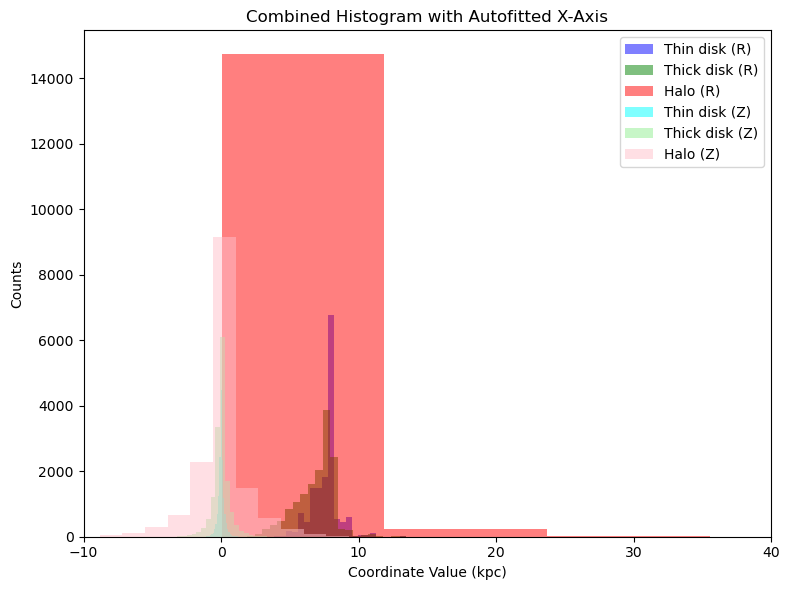

In [22]:
# Choose timeframe (intermediate), e.g. 1 Gyr
ts = np.linspace(0,2,100)*u.Gyr

time_index = np.argmin(np.abs(ts - 1.0 * u.Gyr))  # find the index closer to 1 Gyr

# obtain positions R and Z at that moment
R_thin = a_thin.R(time_index)  # R in kpc
Z_thin = a_thin.z(time_index)  # Z in kpc

R_thick = a_thick.R(time_index)
Z_thick = a_thick.z(time_index)

R_halo = a_halo.R(time_index)
Z_halo = a_halo.z(time_index)


# R histogram
fig1 = pl.figure(figsize=(8, 6))
pl.hist(R_thin, bins=30, alpha=0.5, label='Thin disk', color='blue') # density = True for normalized counts, we didn't normalize them
pl.hist(R_thick, bins=30, alpha=0.5, label='Thick disk', color='green')
pl.hist(R_halo, bins=30, alpha=0.5, label='Halo', color='red')
pl.xlabel('Galactocentric Radius, R (kpc)')
pl.ylabel('Counts')
pl.legend()
pl.tight_layout()
pl.savefig("simulated_histogram1.png", dpi=150, bbox_inches='tight')
pl.show()

# Z histogram 
fig2 = pl.figure(figsize=(8, 6))
pl.hist(Z_thin, bins=30, alpha=0.5, label='Thin disk', color='blue')
pl.hist(Z_thick, bins=30, alpha=0.5, label='Thick disk', color='green')
pl.hist(Z_halo, bins=30, alpha=0.5, label='Halo', color='red')
pl.xlabel('Vertical Coordinate, Z (kpc)')
pl.ylabel('Counts')
pl.legend()
pl.tight_layout()
pl.savefig("simulated_histogram2.png", dpi=150, bbox_inches='tight')
pl.show()




# # Create a single figure for the combined histogram
# fig = pl.figure(figsize=(8, 6))

# # Plot histograms for R and Z on the same graph
# pl.hist(R_thin, bins=30, alpha=0.5, label='Thin disk (R)', color='blue')
# pl.hist(R_thick, bins=30, alpha=0.5, label='Thick disk (R)', color='green')
# pl.hist(R_halo, bins=30, alpha=0.5, label='Halo (R)', color='red')

# pl.hist(Z_thin, bins=30, alpha=0.5, label='Thin disk (Z)', color='cyan')
# pl.hist(Z_thick, bins=30, alpha=0.5, label='Thick disk (Z)', color='lightgreen')
# pl.hist(Z_halo, bins=30, alpha=0.5, label='Halo (Z)', color='pink')

# # Autofit x-axis to the data range
# pl.xlim(-10, 40)

# # Add labels and legend
# pl.xlabel('Coordinate Value (kpc)')
# pl.ylabel('Counts')
# pl.title('Combined Histogram with Autofitted X-Axis')
# pl.legend()
# pl.tight_layout()

# # Save the figure
# pl.savefig("simulated_autofit_xaxis_histogram.png", dpi=150, bbox_inches='tight')

# # Show the plot
# pl.show()

### Extended Report #3: Simulated WD Radii Distribution Comparison
This is the simulated part of part 3

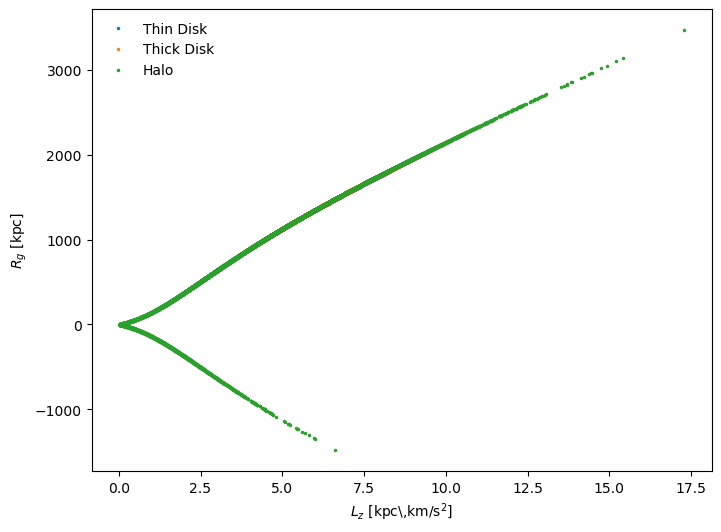

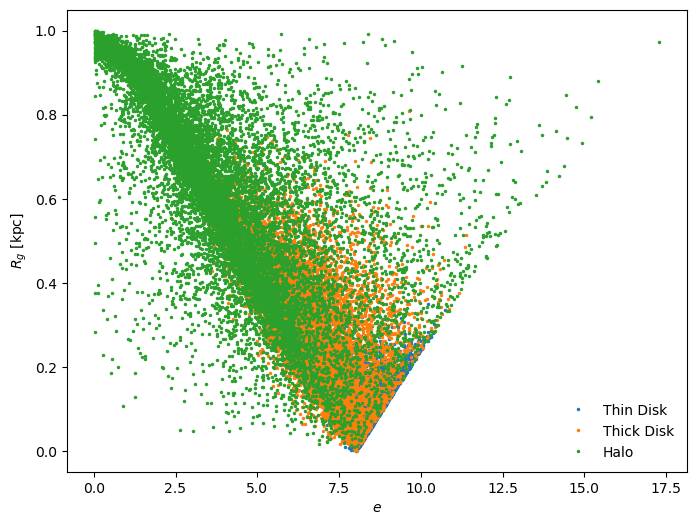

In [13]:
# EXTENDED #1
# We can obtain the value of the guiding center radii by using .rguiding()
# Using all integrated orbits

# Guiding center radius vs Lz
fig1 = pl.figure(figsize=(8, 6))
pl.plot(a_thin.rguiding(),a_thin.Lz(quantity=True), marker='.', ms=3, ls='none', label='Thin Disk')
pl.plot(a_thick.rguiding(),a_thick.Lz(quantity=True), marker='.', ms=3, ls='none', label='Thick Disk')
pl.plot(a_halo.rguiding(),a_halo.Lz(quantity=True), marker='.', ms=3, ls='none', label='Halo')
pl.xlabel(r'$L_z$ [kpc\,km/s$^2$]')
pl.ylabel(r'$R_g$ [kpc]')
pl.savefig("sim_gr_Lz.png", dpi=150, bbox_inches='tight')
pl.legend(frameon=False)
pl.show()

# Guiding center radius vs e
fig2 = pl.figure(figsize=(8, 6))
pl.plot(a_thin.rguiding(),a_thin.e(), marker='.', ms=3, ls='none', label='Thin Disk')
pl.plot(a_thick.rguiding(),a_thick.e(), marker='.', ms=3, ls='none', label='Thick Disk')
pl.plot(a_halo.rguiding(),a_halo.e(), marker='.', ms=3, ls='none', label='Halo')
pl.xlabel(r'$e$')
pl.ylabel(r'$R_g$ [kpc]')
pl.savefig("sim_gr_e.png", dpi=150, bbox_inches='tight')
pl.legend(frameon=False)
pl.show()


## Gaia 100pcWD
### Extended Report #2: Modifying for Observed White Dwarfs with Gaia 100-pcWD Data

We can import a differnt CSV file into a python array in order to generate this with a random forest algorithm. We will use the Gaia 100-pc White Dwarf sample as classified by Torres et al. 2019, MNRAS. 485. 5573-5589.

[('Source_ID', '<U28'), ('Name', '<U19'), ('Random_number', '<i8'), ('RA_deg', '<f8'), ('DEC_deg', '<f8'), ('parallax_mas', '<f8'), ('pmramasyr', '<f8'), ('pmdec_masyr', '<f8'), ('phot_g_mean_mag', '<f8'), ('phot_bp_mean_mag', '<f8'), ('phot_rp_mean_mag', '<f8'), ('bp_rp', '<f8'), ('bp_g', '<f8'), ('g_rp', '<f8'), ('M_g', '<f8'), ('U_kms', '<f8'), ('V_kms', '<f8'), ('W_kms', '<f8'), ('Ilabel_0thin1thick2halo', '<i8')]


e =  0.066 Lz =  1864.4174535284305 km kpc / s
e =  0.166 Lz =  1548.087435179314 km kpc / s
e =  0.627 Lz =  -1655.2581257634054 km kpc / s


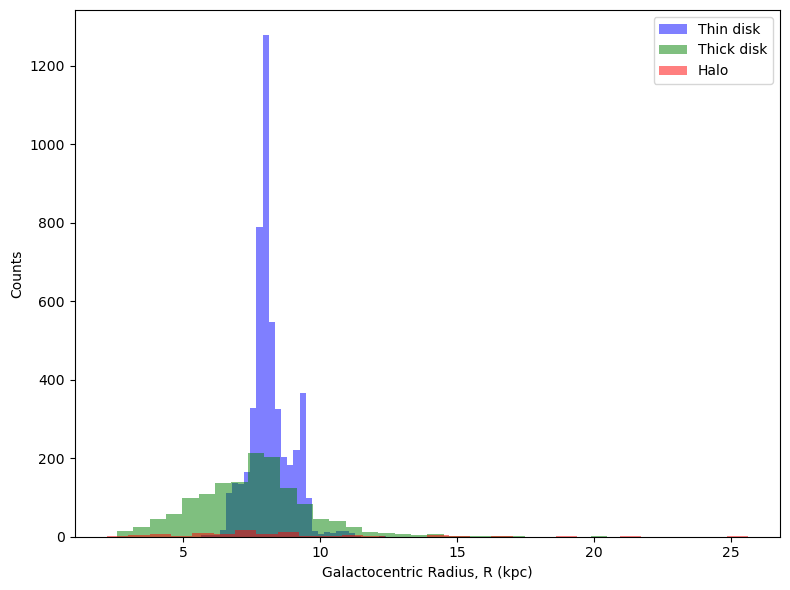

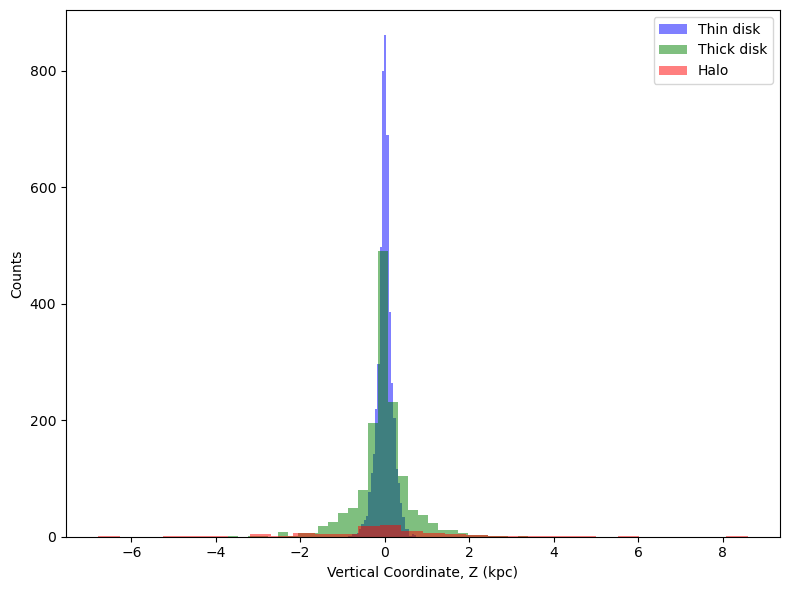

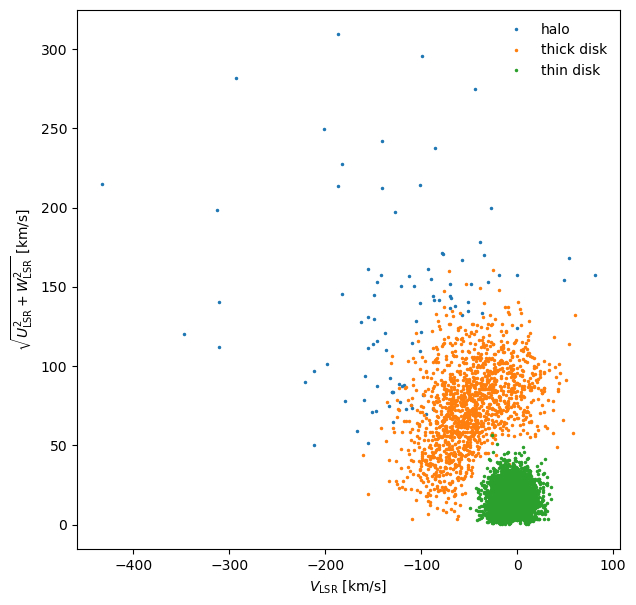

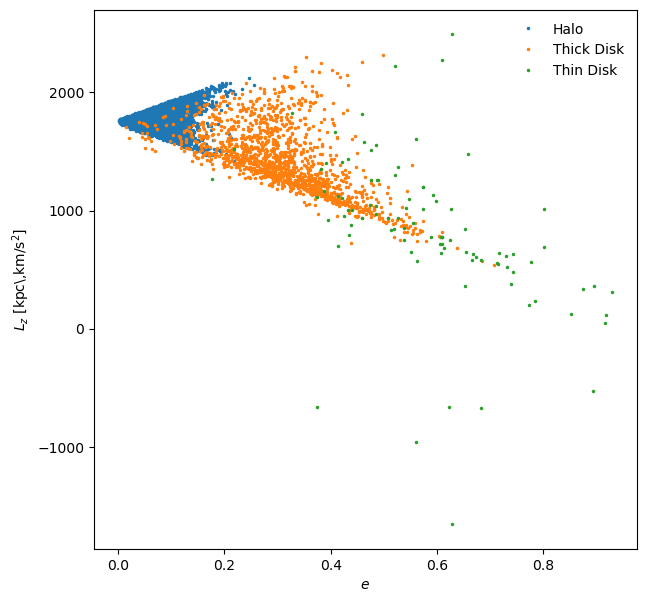

In [26]:
# EXTENDED #2

np.random.seed(0)

# Import Local File
R = np.genfromtxt('Gaia_100pcWD.csv', delimiter=',', names=True, dtype=None, encoding="ASCII")
print(R.dtype)

# masking the galactic components by using the lable defined by Torres et al.
mask_thin = np.where(R['Ilabel_0thin1thick2halo']==0) # 0 for thin disk stars
mask_thick = np.where(R['Ilabel_0thin1thick2halo']==1) # 1 for thick disk stars
mask_halo = np.where(R['Ilabel_0thin1thick2halo']==2) # 2 for halo stars

#------------------------------------
# Integrate
#------------------------------------

star_thin = R[mask_thin]
star_thick = R[mask_thick]
star_halo = R[mask_halo]

ts = np.linspace(0,2,100)*u.Gyr

# Integrate over ONE orbit 
o_thin = Orbit([star_thin['RA_deg'][0],star_thin['DEC_deg'][0],1/star_thin['parallax_mas'][0], # distance=1/parallax
                star_thin['pmramasyr'][0],star_thin['pmdec_masyr'][0], 0.],                    # parallax in miliarcseconds
                 radec=True, ro=R0, zo=z0, vo=V0, solarmotion=v_sun)                           # masyr=miliarcseconds/year
o_thin.integrate(ts,MWPotential2014)

o_thick = Orbit([star_thick['RA_deg'][10],star_thick['DEC_deg'][10],1/star_thick['parallax_mas'][10],
                star_thick['pmramasyr'][10],star_thick['pmdec_masyr'][10], 0.],
                 radec=True, ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
o_thick.integrate(ts,MWPotential2014)

o_halo = Orbit([star_halo['RA_deg'][-1],star_halo['DEC_deg'][-1],1/star_halo['parallax_mas'][-1],
                star_halo['pmramasyr'][-1],star_halo['pmdec_masyr'][-1], 0.],
                 radec=True, ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
o_halo.integrate(ts,MWPotential2014)

# Integrate over ALL of the orbits
a_thin = Orbit([star_thin['RA_deg'][0:5000],star_thin['DEC_deg'][0:5000],1/star_thin['parallax_mas'][0:5000],
                star_thin['pmramasyr'][0:5000],star_thin['pmdec_masyr'][0:5000], np.zeros(len(star_thin[0:5000]))],
                 radec=True, ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
a_thin.integrate(ts,MWPotential2014)

a_thick = Orbit([star_thick['RA_deg'],star_thick['DEC_deg'],1/star_thick['parallax_mas'],
                star_thick['pmramasyr'],star_thick['pmdec_masyr'], np.zeros(len(star_thick))],
                 radec=True, ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
a_thick.integrate(ts,MWPotential2014)

a_halo = Orbit([star_halo['RA_deg'],star_halo['DEC_deg'],1/star_halo['parallax_mas'],
                star_halo['pmramasyr'],star_halo['pmdec_masyr'], np.zeros(len(star_halo))],
                 radec=True, ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
a_halo.integrate(ts,MWPotential2014)


# printing eccentricity and angular momentum (z component)
print('e = ', round(o_thin.e(),3), 'Lz = ', o_thin.Lz(quantity=True))
print('e = ', round(o_thick.e(),3), 'Lz = ', o_thick.Lz(quantity=True))
print('e = ', round(o_halo.e(),3), 'Lz = ', o_halo.Lz(quantity=True))



#-------------------------------------------------------------------
#Plotting the Combined Histograms
#-------------------------------------------------------------------

# Choose intermediate time, 1 Gyr
time_index = np.argmin(np.abs(ts - 1.0 * u.Gyr))  # find the index closer to 1 Gyr

# obtain positions R and Z at that moment
R_thin = a_thin.R(time_index)  # R en kpc
Z_thin = a_thin.z(time_index)  # Z en kpc

R_thick = a_thick.R(time_index)
Z_thick = a_thick.z(time_index)

R_halo = a_halo.R(time_index)
Z_halo = a_halo.z(time_index)

# R histogram
fig1 = pl.figure(figsize=(8, 6))
pl.hist(R_thin, bins=30, alpha=0.5, label='Thin disk', color='blue') # density = True for normalized counts, we didn't normalize them
pl.hist(R_thick, bins=30, alpha=0.5, label='Thick disk', color='green')
pl.hist(R_halo, bins=30, alpha=0.5, label='Halo', color='red')
pl.xlabel('Galactocentric Radius, R (kpc)')
pl.ylabel('Counts')
pl.legend()
pl.tight_layout()
pl.savefig("realwd_histogramR.png", dpi=150, bbox_inches='tight')

# Z histogram 
fig2 = pl.figure(figsize=(8, 6))
pl.hist(Z_thin, bins=30, alpha=0.5, label='Thin disk', color='blue')
pl.hist(Z_thick, bins=30, alpha=0.5, label='Thick disk', color='green')
pl.hist(Z_halo, bins=30, alpha=0.5, label='Halo', color='red')
pl.xlabel('Vertical Coordinate, Z (kpc)')
pl.ylabel('Counts')
pl.legend()
pl.tight_layout()
pl.savefig("realwd_histogramZ.png", dpi=150, bbox_inches='tight')
pl.show()



# # Create a single figure for the combined histogram
# fig = pl.figure(figsize=(8, 6))

# # Plot histograms for R and Z on the same graph
# pl.hist(R_thin, bins=30, alpha=0.5, label='Thin disk (R)', color='blue')
# pl.hist(R_thick, bins=30, alpha=0.5, label='Thick disk (R)', color='green')
# pl.hist(R_halo, bins=30, alpha=0.5, label='Halo (R)', color='red')

# pl.hist(Z_thin, bins=30, alpha=0.5, label='Thin disk (Z)', color='cyan')
# pl.hist(Z_thick, bins=30, alpha=0.5, label='Thick disk (Z)', color='lightgreen')
# pl.hist(Z_halo, bins=30, alpha=0.5, label='Halo (Z)', color='pink')

# # Autofit x-axis to the data range
# pl.xlim(-8, 25)

# # Add labels and legend
# pl.xlabel('Coordinate Value (kpc)')
# pl.ylabel('Counts')
# pl.title('Combined Histogram with Autofitted X-Axis')
# pl.legend()
# pl.tight_layout()

# # Save the figure
# pl.savefig("simulated_autofit_xaxis_histogram.png", dpi=150, bbox_inches='tight')

# # Show the plot
# pl.show()



#---------------------------------------------------------
# Plot Toomre Diagram for Observed Sample
#---------------------------------------------------------

fig = pl.figure(figsize=(7,7))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(111)

# Using ALL integrated orbits

ax1.plot(a_halo.V(),np.sqrt(a_halo.U()**2 + a_halo.W()**2), marker='.', ms=3, ls='none', label='halo')
ax1.plot(a_thick.V(),np.sqrt(a_thick.U()**2 + a_thick.W()**2), marker='.', ms=3, ls='none', label='thick disk')
ax1.plot(a_thin.V(),np.sqrt(a_thin.U()**2 + a_thin.W()**2), marker='.', ms=3, ls='none', label='thin disk')

ax1.set_xlabel(r'$V_{\rm LSR}$ [km/s]')
ax1.set_ylabel(r'$\sqrt{U^2_{\rm LSR} + W^2_{\rm LSR}}$ [km/s]')

pl.legend(frameon=False)

pl.show()


#----------------------------------------------------------------------------
# Plotting Vertical Component of Angular Momentum vs Orbital Eccentricity
#----------------------------------------------------------------------------
fig = pl.figure(figsize=(7,7))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(111)

# Using ALL integrated orbits
ax1.plot(a_thin.e(),a_thin.Lz(), marker='.', ms=3, ls='none', label='Halo')
ax1.plot(a_thick.e(),a_thick.Lz(), marker='.', ms=3, ls='none', label='Thick Disk')
ax1.plot(a_halo.e(),a_halo.Lz(), marker='.', ms=3, ls='none', label='Thin Disk')

ax1.set_xlabel(r'$e$')
ax1.set_ylabel(r'$L_z$ [kpc\,km/s$^2$]')

pl.legend(frameon=False)
pl.show()




## Gaia 100pcSTARS
### Extended Report #3: Comparing Distributions of Guiding-Center Radii using Gaia100pcSTARS
We can use orbit.rguiding() for the simulated or real stars. We need to note differences between e or L_z

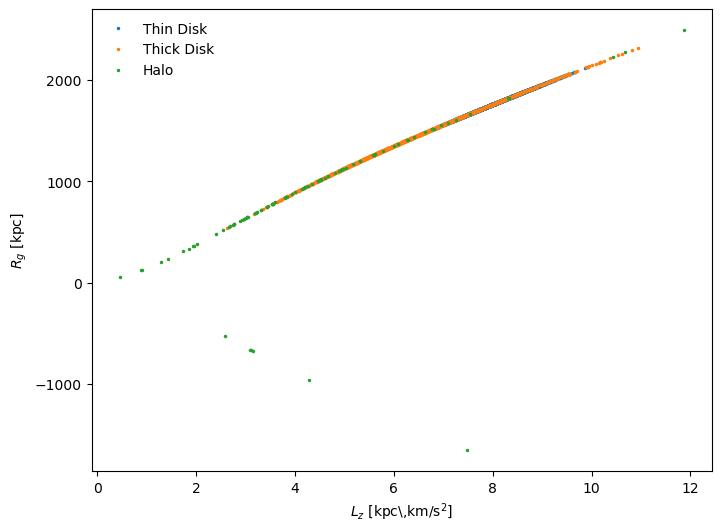

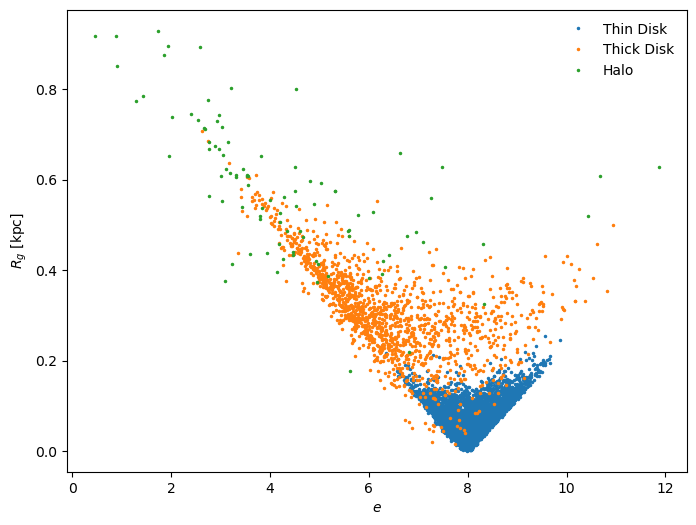

[('source_id', '<i8'), ('ra', '<f8'), ('dec', '<f8'), ('parallax', '<f8'), ('pmra', '<f8'), ('pmdec', '<f8'), ('radial_velocity', '<f8')]


e =  0.053 Lz =  1809.4390132968776 km kpc / s


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


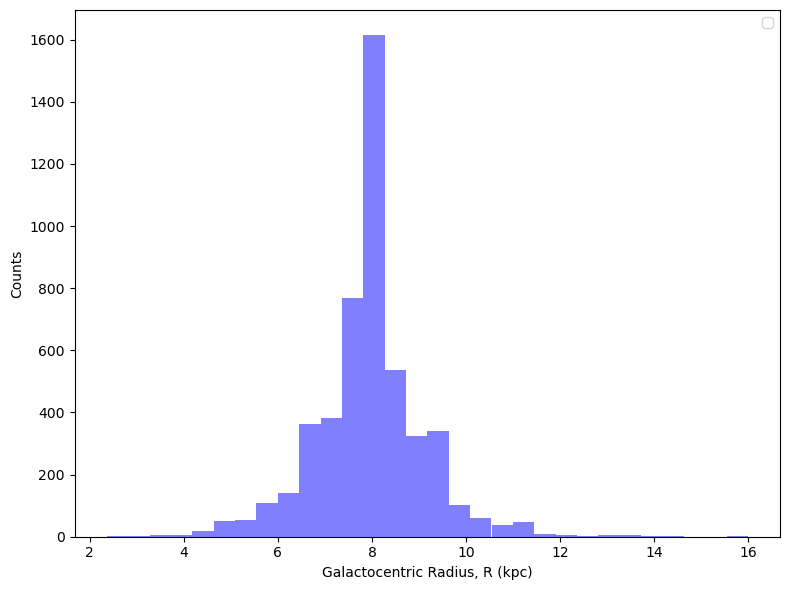

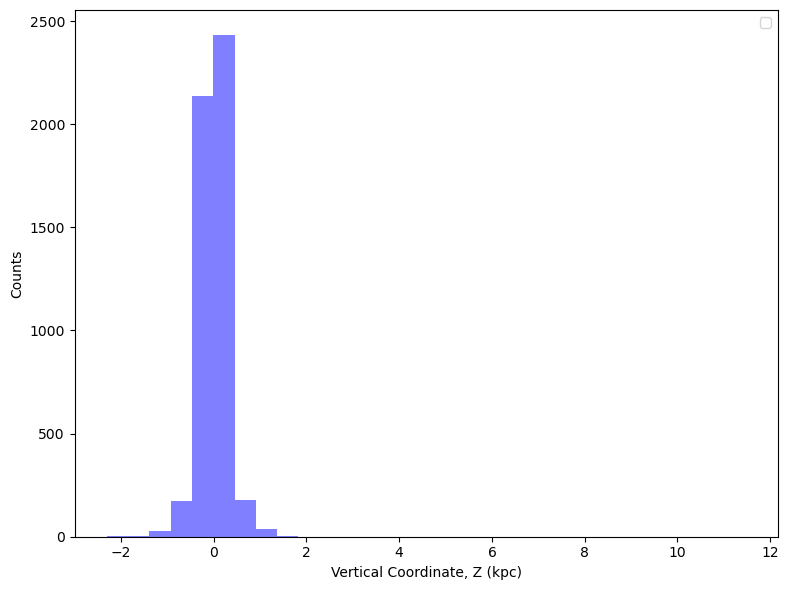

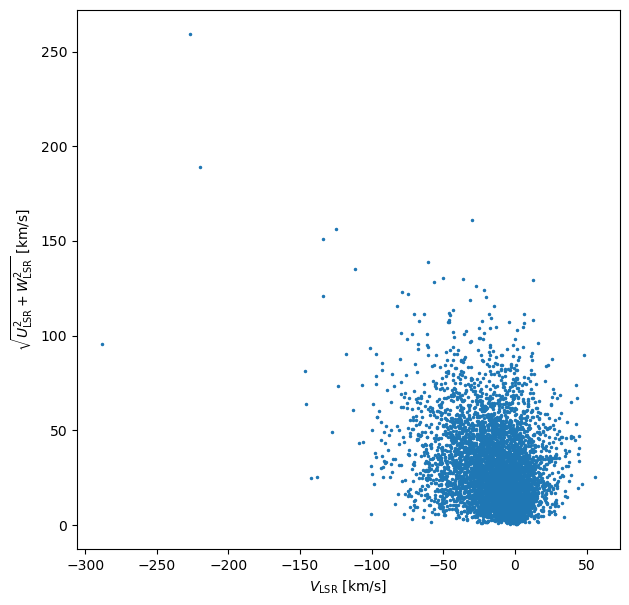

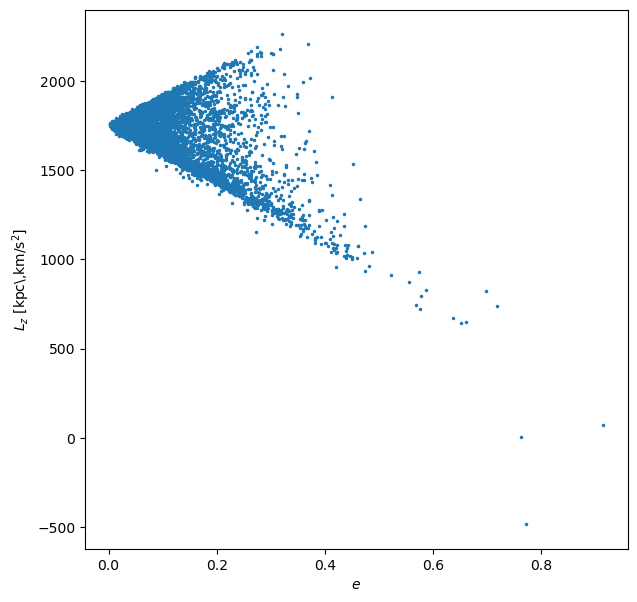

In [27]:
# EXTENDED #3
# We obtain the value of guiding center radii by using .rguiding()


#----------------------------------------
# Using simulated Stars
#----------------------------------------


# Using ALL integrated orbits

# Guiding center radius vs Lz modified by using .rguiding()
fig1 = pl.figure(figsize=(8, 6))
pl.plot(a_thin.rguiding(),a_thin.Lz(quantity=True), marker='.', ms=3, ls='none', label='Thin Disk')
pl.plot(a_thick.rguiding(),a_thick.Lz(quantity=True), marker='.', ms=3, ls='none', label='Thick Disk')
pl.plot(a_halo.rguiding(),a_halo.Lz(quantity=True), marker='.', ms=3, ls='none', label='Halo')
pl.xlabel(r'$L_z$ [kpc\,km/s$^2$]')
pl.ylabel(r'$R_g$ [kpc]')
pl.savefig("sim_gr_Lz.png", dpi=150, bbox_inches='tight')
pl.legend(frameon=False)
pl.show()

# guiding center radius vs e
fig2 = pl.figure(figsize=(8, 6))
pl.plot(a_thin.rguiding(),a_thin.e(), marker='.', ms=3, ls='none', label='Thin Disk')
pl.plot(a_thick.rguiding(),a_thick.e(), marker='.', ms=3, ls='none', label='Thick Disk')
pl.plot(a_halo.rguiding(),a_halo.e(), marker='.', ms=3, ls='none', label='Halo')
pl.xlabel(r'$e$')
pl.ylabel(r'$R_g$ [kpc]')
pl.savefig("sim_gr_e.png", dpi=150, bbox_inches='tight')
pl.legend(frameon=False)
pl.show()




#-------------------------------------------
# Using Real Star Data
#-------------------------------------------
# Import Local Function for Gaia 100-pc stars
R = np.genfromtxt('Gaia100pcStars.csv', delimiter=',', names=True, dtype=None, encoding="ASCII")
print(R.dtype)

# Create again the three orbits
stars = R
ts = np.linspace(0,2,100)*u.Gyr

# integrate ONE orbit only
o_stars = Orbit([stars['ra'][0],stars['dec'][0],1/stars['parallax'][0], # distance=1/parallax
                stars['pmra'][0],stars['pmdec'][0], 0.],                # parallax in miliarcseconds
                 radec=True, ro=R0, zo=z0, vo=V0, solarmotion=v_sun)    # masyr=miliarcseconds/year
o_stars.integrate(ts,MWPotential2014)

# integrate ALL orbits
a_stars = Orbit([stars['ra'][0:5000],stars['dec'][0:5000],1/stars['parallax'][0:5000],
                stars['pmra'][0:5000],stars['pmdec'][0:5000], np.zeros(len(stars[0:5000]))],
                 radec=True, ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
a_stars.integrate(ts,MWPotential2014)


# Print eccentricity and angular momentum (z component)
print('e = ', round(o_stars.e(),3), 'Lz = ', o_stars.Lz(quantity=True))



#---------------------------------------------
# Plot Combined Histograms
#---------------------------------------------
# we choose an intermediate time, 1 Gyr
time_index = np.argmin(np.abs(ts - 1.0 * u.Gyr))  # find the index closer to 1 Gyr

# obtain positions R and Z at that moment
R_stars = a_stars.R(time_index)  # R en kpc
Z_stars = a_stars.z(time_index)  # Z en kpc

# R histogram
fig1 = pl.figure(figsize=(8, 6))
pl.hist(R_stars, bins=30, alpha=0.5, color='blue') # density = True for normalized counts, we didn't normalize them
pl.xlabel('Galactocentric Radius, R (kpc)')
pl.ylabel('Counts')
pl.legend()
pl.tight_layout()
pl.savefig("realstars_histogramR.png", dpi=150, bbox_inches='tight')

# Z histogram 
fig2 = pl.figure(figsize=(8, 6))
pl.hist(Z_stars, bins=30, alpha=0.5, color='blue')
pl.xlabel('Vertical Coordinate, Z (kpc)')
pl.ylabel('Counts')
pl.legend()
pl.tight_layout()
pl.savefig("realstars_histogramZ.png", dpi=150, bbox_inches='tight')
pl.show()




#-----------------------------------------------
# Plotting Toomre Diagram
#-----------------------------------------------
fig = pl.figure(figsize=(7,7))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(111)

# using all of the integrated orbits

ax1.plot(a_stars.V(),np.sqrt(a_stars.U()**2 + a_stars.W()**2), marker='.', ms=3, ls='none')

ax1.set_xlabel(r'$V_{\rm LSR}$ [km/s]')
ax1.set_ylabel(r'$\sqrt{U^2_{\rm LSR} + W^2_{\rm LSR}}$ [km/s]')

pl.show()



#-----------------------------------------------
# Plotting Vertical Component of Momentum L_z
#-----------------------------------------------
fig = pl.figure(figsize=(7,7))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(111)

# Using ALL integrated orbits
ax1.plot(a_stars.e(),a_stars.Lz(), marker='.', ms=3, ls='none')

ax1.set_xlabel(r'$e$')
ax1.set_ylabel(r'$L_z$ [kpc\,km/s$^2$]')

pl.show()



### Extended Report #4: Setting v_R (Radial Velocity) = 0:
For this, we can modify the orbit input command after initializing the orbit

e =  0.029758378819745634 Lz =  1716.0534816801414 km kpc / s
e =  0.45732853056646744 Lz =  1006.2618000451755 km kpc / s
e =  0.07359433133847959 Lz =  1880.3006740306503 km kpc / s


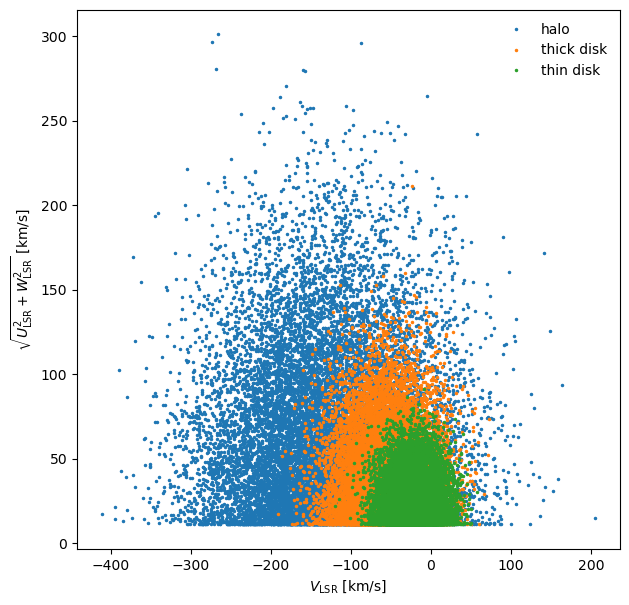

In [16]:
# EXTENDED #4
# Re-using the code from above:

# Convert to Cylindrical Coordinates
XYZ = [8.030,0.0,0.025]

# Create 3 different matrices for each type of star.
RTZ_thin = coords.rect_to_cyl(XYZ[0], XYZ[1], XYZ[2])
vRTZ_thin = coords.rect_to_cyl_vec(nUVW_thin[:,0],nUVW_thin[:,1],nUVW_thin[:,2],XYZ[0], XYZ[1], XYZ[2], cyl=False)

RTZ_thick = coords.rect_to_cyl(XYZ[0], XYZ[1], XYZ[2])
vRTZ_thick = coords.rect_to_cyl_vec(nUVW_thick[:,0],nUVW_thick[:,1],nUVW_thick[:,2],XYZ[0], XYZ[1], XYZ[2], cyl=False)

RTZ_halo = coords.rect_to_cyl(XYZ[0], XYZ[1], XYZ[2])
vRTZ_halo = coords.rect_to_cyl_vec(nUVW_halo[:,0],nUVW_halo[:,1],nUVW_halo[:,2],XYZ[0], XYZ[1], XYZ[2], cyl=False)


# We can now convert the tuples into arrays to modify later
RTZ_thin=np.array(RTZ_thin)
RTZ_thick=np.array(RTZ_thick).T
RTZ_halo=np.array(RTZ_halo).T

vRTZ_thin=np.array(vRTZ_thin).T
vRTZ_thick=np.array(vRTZ_thick).T
vRTZ_halo=np.array(vRTZ_halo).T

# Set Radial Velocity to 0
for i in range(len(vRTZ_thin)):
    vRTZ_thin[i, 0]=0
    vRTZ_thick[i, 0]=0
    vRTZ_halo[i, 0]=0

# Compute the same now:
star_thin=np.zeros((N,6))
star_thick=np.zeros((N,6))
star_halo=np.zeros((N,6))

for i in range(N):
    star_thin[i, 0] = RTZ_thin[0]/8.
    star_thin[i, 1] = vRTZ_thin[i, 0] / 220. 
    star_thin[i, 2] = 1 + vRTZ_thin[i, 1] / 220. 
    star_thin[i, 3] = RTZ_thin[2] / 8. 
    star_thin[i, 4] = vRTZ_thin[i, 2] / 220. 
    star_thin[i, 5] = RTZ_thin[1]  

    star_thick[i, 0] = RTZ_thick[0]/8.
    star_thick[i, 1] = vRTZ_thick[i, 0] / 220. 
    star_thick[i, 2] = 1 + vRTZ_thick[i, 1] / 220. 
    star_thick[i, 3] = RTZ_thick[2] / 8. 
    star_thick[i, 4] = vRTZ_thick[i, 2] / 220. 
    star_thick[i, 5] = RTZ_thick[1]

    star_halo[i, 0] = RTZ_halo[0]/8.
    star_halo[i, 1] = vRTZ_halo[i, 0] / 220. 
    star_halo[i, 2] = 1 + vRTZ_halo[i, 1] / 220. 
    star_halo[i, 3] = RTZ_halo[2] / 8. 
    star_halo[i, 4] = vRTZ_halo[i, 2] / 220. 
    star_halo[i, 5] = RTZ_halo[1]

ts = np.linspace(0,2,1000)*u.Gyr # to test only

# we integrate ONE orbit

o_thin = Orbit(star_thin[0], ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
o_thin.integrate(ts,MWPotential2014)

o_thick = Orbit(star_thick[0], ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
o_thick.integrate(ts,MWPotential2014)

o_halo = Orbit(star_halo[0], ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
o_halo.integrate(ts,MWPotential2014)

# we integrate all orbits

a_thin = Orbit(star_thin, ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
a_thin.integrate(ts,MWPotential2014)

a_thick = Orbit(star_thick, ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
a_thick.integrate(ts,MWPotential2014)

a_halo = Orbit(star_halo, ro=R0, zo=z0, vo=V0, solarmotion=v_sun)
a_halo.integrate(ts,MWPotential2014)

# printing eccentricity and angular momentum (z component)
print('e = ', o_thin.e(), 'Lz = ', o_thin.Lz(quantity=True))
print('e = ', o_thick.e(), 'Lz = ', o_thick.Lz(quantity=True))
print('e = ', o_halo.e(), 'Lz = ', o_halo.Lz(quantity=True))


# Now plotting the Toomre Diagram
fig = pl.figure(figsize=(7,7))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(111)

# using all of the integrated orbits

ax1.plot(a_halo.V(),np.sqrt(a_halo.U()**2 + a_halo.W()**2), marker='.', ms=3, ls='none', label='halo')
ax1.plot(a_thick.V(),np.sqrt(a_thick.U()**2 + a_thick.W()**2), marker='.', ms=3, ls='none', label='thick disk')
ax1.plot(a_thin.V(),np.sqrt(a_thin.U()**2 + a_thin.W()**2), marker='.', ms=3, ls='none', label='thin disk')

ax1.set_xlabel(r'$V_{\rm LSR}$ [km/s]')
ax1.set_ylabel(r'$\sqrt{U^2_{\rm LSR} + W^2_{\rm LSR}}$ [km/s]')
pl.savefig('sim_Toomre_diagram_Vr=0')
pl.legend(frameon=False)

pl.show()


### Extended Report #6: Employ Potentials McMillan17 and Irrgang13I

### Extra Unnecessary Code:
Below we integrate for longer and plot the orbits again:

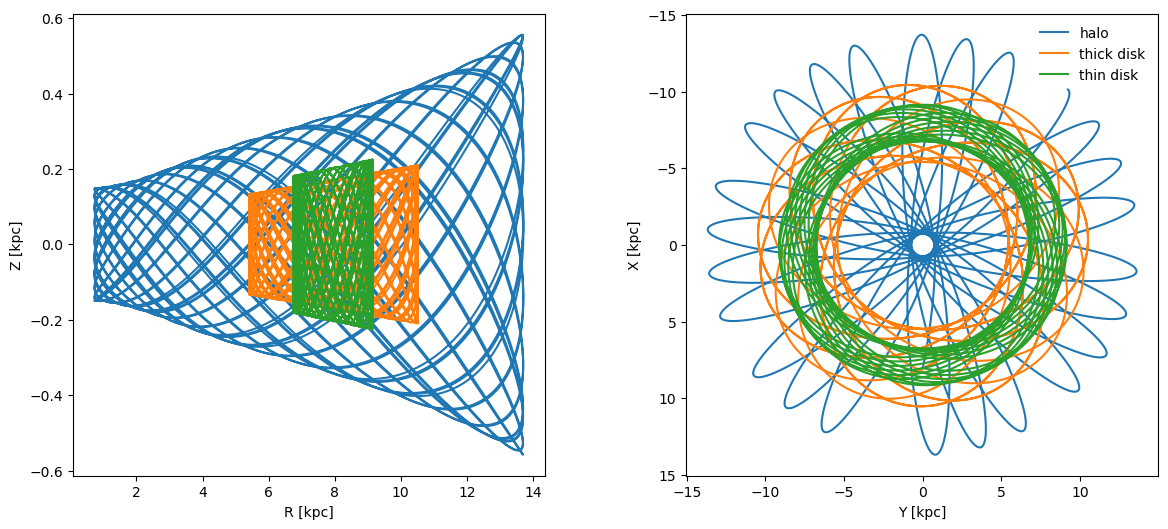

In [72]:
# Number of Gigayears we integrate over
num_gyrs = 4

ts = np.linspace(0,num_gyrs,10000)*u.Gyr


o_thin.integrate(ts,MWPotential2014)

o_thick.integrate(ts,MWPotential2014)

o_halo.integrate(ts,MWPotential2014)


# Plot figures
fig = pl.figure(figsize=(14,6))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(121)

ax1.plot(o_halo.R(ts,quantity=True),o_halo.z(ts,quantity=True))
ax1.plot(o_thick.R(ts,quantity=True),o_thick.z(ts,quantity=True))
ax1.plot(o_thin.R(ts,quantity=True),o_thin.z(ts,quantity=True))

ax1.set_xlabel('R [kpc]')
ax1.set_ylabel('Z [kpc]')


ax2 = fig.add_subplot(122)

ax2.plot(o_halo.y(ts,quantity=True),o_halo.x(ts,quantity=True), label='halo')
ax2.plot(o_thick.y(ts,quantity=True),o_thick.x(ts,quantity=True), label='thick disk')
ax2.plot(o_thin.y(ts,quantity=True),o_thin.x(ts,quantity=True), label='thin disk')

ax2.set_xlabel('Y [kpc]')
ax2.set_ylabel('X [kpc]')

pl.legend(frameon=False)

ax2.invert_yaxis()
pl.show()


We now plot the Galactic Radial Velocity Component:

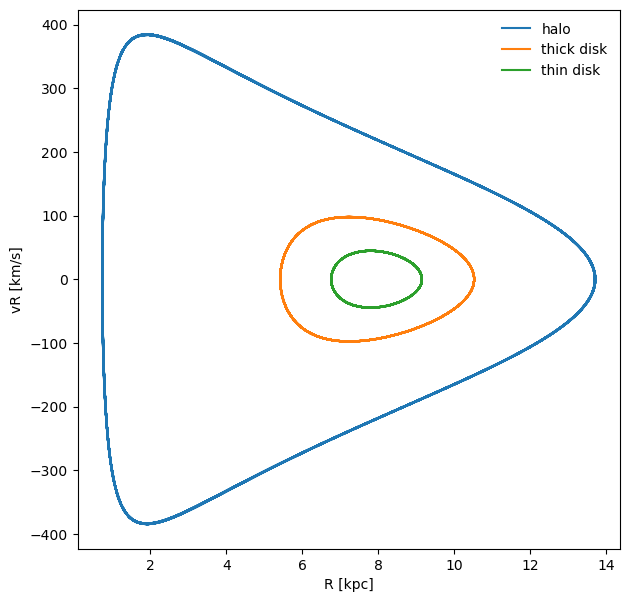

In [73]:
fig = pl.figure(figsize=(7,7))
fig.subplots_adjust(wspace=0.3)
ax1 = fig.add_subplot(111)

ax1.plot(o_halo.R(ts,quantity=True),o_halo.vR(ts,quantity=True), label='halo')
ax1.plot(o_thick.R(ts,quantity=True),o_thick.vR(ts,quantity=True), label='thick disk')
ax1.plot(o_thin.R(ts,quantity=True),o_thin.vR(ts,quantity=True), label='thin disk')

pl.legend(frameon=False)

ax1.set_xlabel('R [kpc]')
ax1.set_ylabel('vR [km/s]')
pl.show()